In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sea
from scipy import stats
import matplotlib.pyplot as plt
from housing_elements import utils, los_altos_permits, san_francisco_permits, san_jose_permits, map_utils
from pathlib import Path

In [2]:
from importlib import reload
reload(los_altos_permits)
reload(san_francisco_permits)
reload(utils)

<module 'housing_elements.utils' from '/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/utils.py'>

In [3]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
# Silence an annoying warning that I get when running pd.read_excel
import warnings
warnings.filterwarnings("ignore", message="Data Validation extension is not supported and will be removed")

# Load sites and permits DataFrames for each city

In [5]:
sites_df = utils.load_all_sites()

In [6]:
all_cities = sites_df.jurisdict.unique()

In [7]:
len(all_cities)

108

In [8]:
%%time
cities_with_sites = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_sites[city] = utils.load_site_inventory(city)
            cities_with_sites[city].relcapcty.sum()
        except Exception:
            pass

CPU times: user 9.26 s, sys: 243 ms, total: 9.5 s
Wall time: 10.1 s


In [9]:
len(cities_with_sites)

108

In [10]:
%%time
cities_with_permits = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_permits[city] = utils.load_all_new_building_permits(city)
        except Exception:
            print(city, file=sys.stderr)

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
Contra Costa County
Alameda County
Corte Madera
Marin County
Saint Helena
Napa County
/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
Hillsborough
San Mateo County
Sonoma County


CPU times: user 5min 19s, sys: 7.59 s, total: 5min 27s
Wall time: 5min 38s


Solano County


In [11]:
len(cities_with_permits)

98

## Dump match results to JSON, for use in website

In [ ]:
reload(utils)
reload(map_utils)
map_utils.write_matches_to_files(
    cities_with_sites,
    cities_with_permits,
    Path('./map_results')
)

 19%|█▊        | 20/108 [00:20<01:26,  1.02it/s]

## Data Cleaning Factoids

### Realistic Capacity

#### Pre-Existing Nulls

Two ways to calculate NA realistic capacities come to the same conclusion

In [13]:
rhna5 = sites_df[sites_df.rhnacyc == 'RHNA5']

In [14]:
rhna5.relcapcty[rhna5.relcapcty.isna()].shape

(2910,)

In [15]:
rhna5[(rhna5.relcapcty.str.contains("/^([^0-9]*)$/") != False)].shape

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(2910, 35)

In [16]:
rhna5.shape

(20849, 35)

In [17]:
2910 / rhna5.shape[0]

0.13957503957024317

### Proportion of nulls that are our fault versus theirs

In [18]:
for city, site in cities_with_sites.items():
    num_fail_parse_realcap = site.realcap_parse_fail.sum()
    num_fail_parse_allowden = site.allowden_parse_fail.sum()
    if num_fail_parse_realcap or num_fail_parse_allowden:
        print(city, end='\t')
    if num_fail_parse_realcap:
        print('Realcap', num_fail_parse_realcap)
    if num_fail_parse_allowden:
        print('Allowden', num_fail_parse_allowden)

San Ramon	Allowden 1
Newark	Allowden 1
Danville	Allowden 9
El Cerrito	Allowden 7
Walnut Creek	Allowden 90
Corte Madera	Allowden 1
Pittsburg	Allowden 1
Piedmont	Allowden 58
Sausalito	Allowden 87
Fairfax	Allowden 48
Novato	Allowden 5
Atherton	Allowden 2
Woodside	Allowden 266
San Mateo County	Allowden 136
Portola Valley	Allowden 8
Windsor	Allowden 1


In [19]:
sum([site.allowden_parse_fail.sum() for city, site in cities_with_sites.items()])

721

In [20]:
sum([site.realcap_parse_fail.sum() for city, site in cities_with_sites.items()])

0

In [21]:
sum([site.shape[0] for city, site in cities_with_permits.items()])

39851

In [22]:
721 / 39851

0.01809239416827683

In [23]:
sum([site.allowden_not_listed.sum() for city, site in cities_with_sites.items()])

5527

In [24]:
721 / (5547 + 721)

0.11502871729419273

11% of allowable density nulls are our fault. None of the realistic capacity nulls are our fault.

#### Degenerate Rows

In [25]:
no_realcap = pd.to_numeric(rhna5.relcapcty, errors='coerce') == 0
no_allowden = pd.to_numeric(rhna5.allowden, errors='coerce') == 0
no_locacreage = pd.to_numeric(rhna5.locacres, errors='coerce') == 0
no_gacreage = pd.to_numeric(rhna5.gacres, errors='coerce') == 0

In [26]:
rhna5[no_realcap & no_locacreage].shape

(14, 35)

In [27]:
rhna5[no_gacreage & no_locacreage].shape

(0, 35)

In [28]:
rhna5[no_gacreage].shape

(0, 35)

In [29]:
rhna5[no_realcap & no_allowden].shape

(901, 35)

In [30]:
rhna5[no_realcap & no_allowden & no_locacreage].shape

(0, 35)

I wouldn't say there are any degenerate rows. Even when locacreage is zero, we can rely on gacreage instead. 

There are, however, 901 sites with no realistic capacity and no allowable density. What kind of sites are these?

In [31]:
rhna5[no_realcap & no_allowden].jurisdict.value_counts()

San Francisco       884
Moraga               14
San Mateo County      2
Martinez              1
Name: jurisdict, dtype: int64

In [32]:
rhna5[no_realcap & no_allowden].sample(5, random_state =0)

,objectid,rhnacyc,rhnayrs,county,jurisdict,apn,locapn,genplan,zoning,gacres,...,infcapcty,siteconst,sitetype,pdaparcel,bundled,existuse,localnote,Shape__Are,Shape__Len,geometry
28077,70211,RHNA5,2015-2023,6075,San Francisco,4227/031,4227/031,Central Waterfront,PDR-1-G,0.056,...,None,None,Underutilized,Y,None,Dwelling,None,2.312208e-08,0.000814,"POLYGON ((-122.39100 37.75430, -122.39132 37.7..."
30283,72417,RHNA5,2015-2023,6075,San Francisco,5434B/002,5434B/002,"BVHP Area A,B",PDR-2,0.697,...,None,None,Underutilized,Y,None,Industrial,None,2.884321e-07,0.002368,"POLYGON ((-122.39907 37.72771, -122.39941 37.7..."
33511,75645,RHNA5,2015-2023,6075,San Francisco,5333/029,5333/029,"BVHP Area A,B",PDR-2,0.057,...,None,None,Underutilized,Y,None,Industrial,None,2.374463e-08,0.000763,"POLYGON ((-122.40177 37.73906, -122.40197 37.7..."
32095,74229,RHNA5,2015-2023,6075,San Francisco,5230/021,5230/021,"BVHP Area A,B",PDR-2,1.122,...,None,None,Vacant,Y,None,Vacant,None,4.643043e-07,0.004282,"POLYGON ((-122.39653 37.74671, -122.39660 37.7..."
31946,74080,RHNA5,2015-2023,6075,San Francisco,4811/011,4811/011,"BVHP Area A,B",PDR-2,0.229,...,None,None,Underutilized,Y,None,Industrial,None,9.496034e-08,0.001248,"POLYGON ((-122.38719 37.72667, -122.38739 37.7..."


They're mostly in San Francisco and have a zoning type of PDR. According to SF's website, "In order to protect PDR, residential development would be prohibited, while office, retail, and institutional uses (schools, hospitals, etc.) would be limited. HOWEVER, residences, offices and retail which currently exist legally in these areas may stay indefinitely."


In [33]:
sf_sites = cities_with_sites['San Francisco']
sf_sites_fixed = sf_sites[
    sf_sites['relcapcty'] != 0
]
cities_with_sites['San Francisco'] = sf_sites_fixed

In [36]:
sf_sites.shape

(5254, 30)

## Results

In [40]:
def get_results_for_city(city: str, match_by: str) -> pd.DataFrame:
    permits = cities_with_permits[city]
    sites = cities_with_sites[city]
    
    nonvacant_matches, nonvacant_sites, nonvacant_ratio = utils.calculate_pdev_for_nonvacant_sites(sites, permits, match_by)
    vacant_matches, vacant_sites, vacant_ratio = utils.calculate_pdev_for_vacant_sites(sites, permits, match_by)
    all_matches, all_sites, all_ratio = utils.calculate_pdev_for_inventory(sites, permits, match_by)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': nonvacant_ratio,
        'P(dev) for vacant sites': vacant_ratio,
        'P(dev) for inventory': all_ratio,
        '# nonvacant matches': f'{nonvacant_matches} / {nonvacant_sites}',
        '# vacant matches': f'{vacant_matches} / {vacant_sites}',
        '# matches': f'{all_matches} / {all_sites}',
    }

In [41]:
cities = [city for city in all_cities if city in cities_with_permits and city in cities_with_sites]

In [42]:
len(cities)

98

In [43]:
%%time
with HiddenPrints():
    results_df = pd.DataFrame([get_results_for_city(city, match_by='apn') for city in cities])

CPU times: user 8.16 s, sys: 374 ms, total: 8.54 s
Wall time: 8.64 s


In [44]:
results_df[results_df['P(dev) for inventory'] == 0].City.values

array(['Albany', 'Alameda', 'Antioch', 'Union City', 'Walnut Creek',
       'Moraga', 'Hercules', 'Oakley', 'Tiburon', 'Sausalito', 'Ross',
       'Millbrae', 'Pacifica', 'Gilroy', 'East Palo Alto', 'Los Gatos',
       'Saratoga', 'Rohnert Park', 'Suisun City', 'Rio Vista',
       'Monte Sereno'], dtype=object)

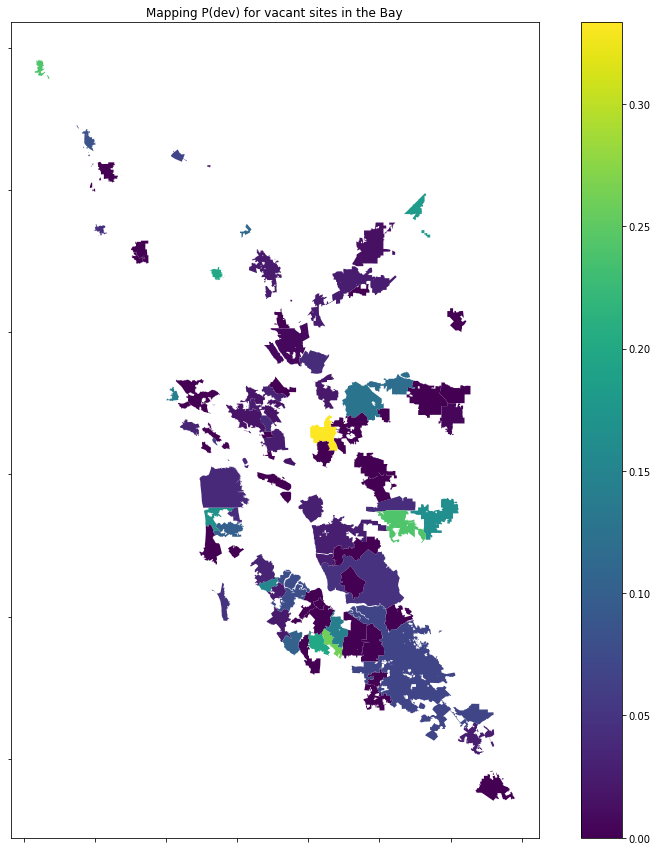

In [45]:
utils.map_qoi('P(dev) for vacant sites', results_df)

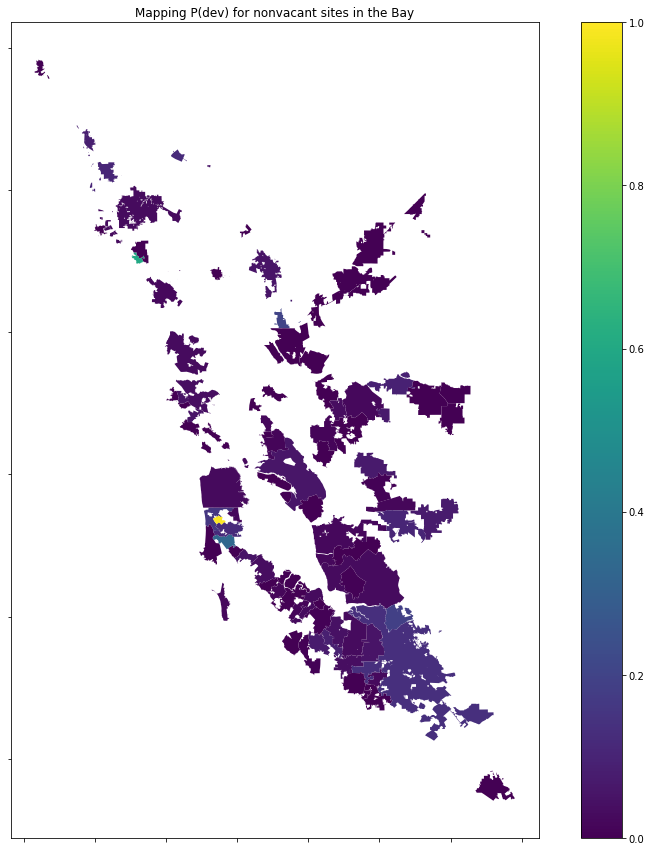

In [46]:
utils.map_qoi('P(dev) for nonvacant sites', results_df)

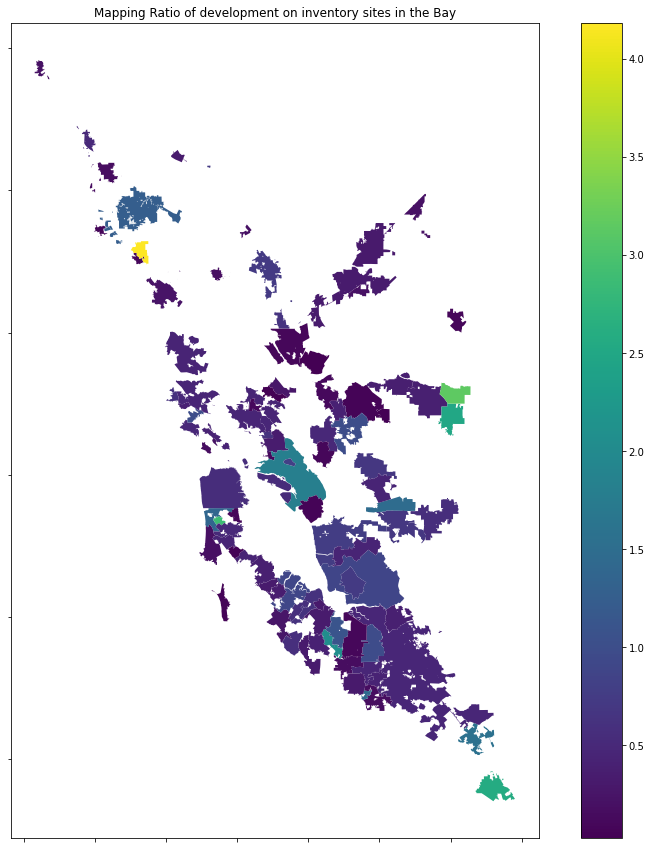

In [47]:
utils.map_qoi('Ratio of development on inventory sites', results_df)

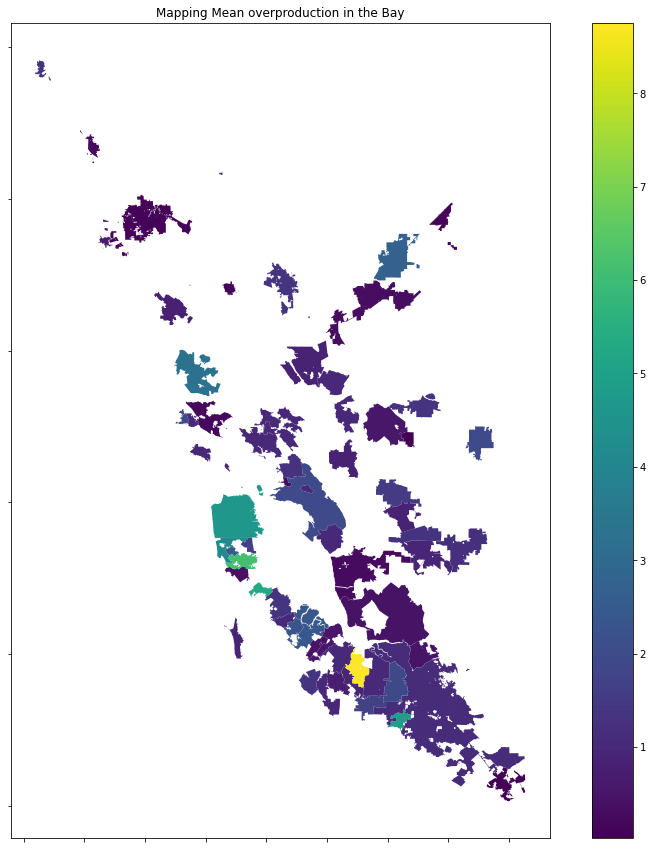

In [48]:
utils.map_qoi('Mean overproduction', results_df)

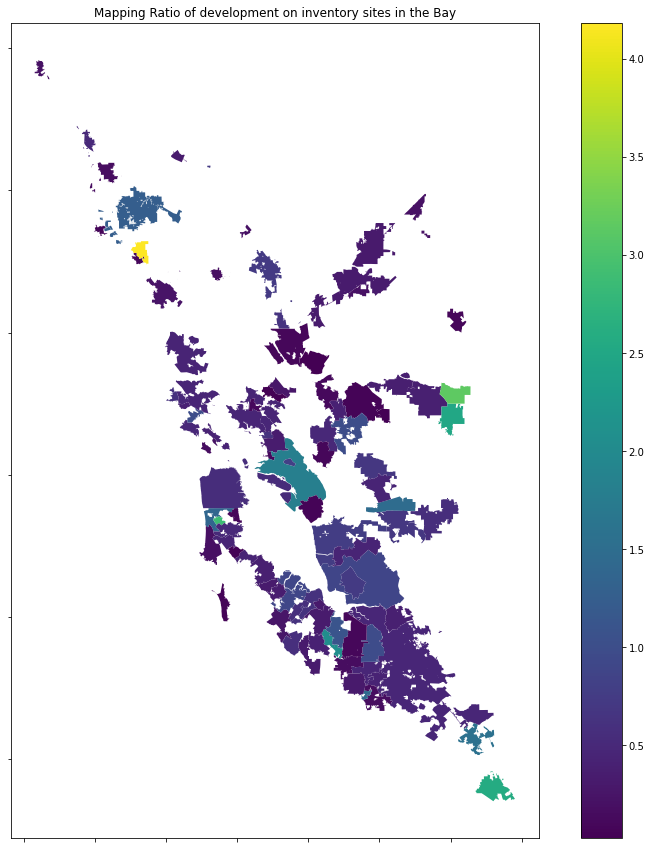

In [49]:
utils.map_qoi('Ratio of development on inventory sites', results_df)

In [50]:
results_df[results_df['P(dev) for inventory'].isna()]

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
31,Orinda,NaN,NaN,0.0,NaN,NaN,NaN,0 / 0,0 / 0,0 / 0
63,Foster City,NaN,NaN,0.0,NaN,NaN,NaN,0 / 0,0 / 0,0 / 0


In [51]:
sites_df[sites_df.jurisdict == 'Orinda']

,objectid,rhnacyc,rhnayrs,county,jurisdict,apn,locapn,genplan,zoning,gacres,...,infcapcty,siteconst,sitetype,pdaparcel,bundled,existuse,localnote,Shape__Are,Shape__Len,geometry
3167,45301,RHNA4,2007-2014,6013,Orinda,260-191-007,260-191-007,Mixed-Use PD (13 acres) & Business and Profess...,PD,11.001,...,None,None,Approved,Y,None,"OUSD offices, City and OUSD temporary corporat...",None,4.562342e-06,0.012552,"POLYGON ((-122.18291 37.88445, -122.18166 37.8..."
3168,45302,RHNA4,2007-2014,6013,Orinda,260-200-017,260-200-017,Public and Semipublic,"Public, Semipublic and Utility",1.455,...,None,None,Vacant,Y,None,Vacant fomer library building,None,6.034702e-07,0.003162,"POLYGON ((-122.18945 37.88495, -122.18938 37.8..."
3169,45303,RHNA4,2007-2014,6013,Orinda,260-200-001,260-200-001,Residential Multi-family,Residential Medium-Density District,9.277,...,None,None,Vacant,Y,None,Vacant,want to rezone to allow 20 du/ac,3.847480e-06,0.008740,"POLYGON ((-122.18350 37.88465, -122.18351 37.8..."


In [52]:
reload(utils)
for city, permits in cities_with_permits.items():
    print(city, '\t', round(utils.fraction_apns_nan(permits), 2))

Berkeley 	 0.01
Albany 	 0.01
Alameda 	 0.43
Livermore 	 0.01
Fremont 	 0.4
San Ramon 	 0.01
Newark 	 0.34
Brentwood 	 0.27
Hayward 	 0.29
Emeryville 	 0.14
Pleasanton 	 0.15
San Leandro 	 0.04
Concord 	 0.39
Richmond 	 0.02
Martinez 	 0.52
Clayton 	 0.75
Pinole 	 0.33
Oakland 	 0.33
San Francisco 	 0.19
Dublin 	 0.77
Antioch 	 0.25
Lafayette 	 0.03
Danville 	 0.32
San Pablo 	 0.19
Napa 	 0.21
El Cerrito 	 0.16
Union City 	 0.12
Walnut Creek 	 0.38
Moraga 	 0.06
Hercules 	 0.23
Oakley 	 0.25
Orinda 	 0.18
Pittsburg 	 0.53
Pleasant Hill 	 0.38
American Canyon 	 0.56
Larkspur 	 0.51
Piedmont 	 0.0
San Rafael 	 0.02
Calistoga 	 0.12
Tiburon 	 0.0
Sausalito 	 0.36
Yountville 	 0.27
San Anselmo 	 0.29
Belvedere 	 0.43
Fairfax 	 0.06
Ross 	 0.17
Novato 	 0.2
Half Moon Bay 	 0.25
Millbrae 	 0.22
San Bruno 	 0.08
Mill Valley 	 0.31
Brisbane 	 0.54
Atherton 	 0.18
Menlo Park 	 0.42
Pacifica 	 0.0
Redwood City 	 0.13
Belmont 	 0.09
San Mateo 	 0.15
Colma 	 0.23
Daly City 	 0.04
San Carlos 	 0.05

In [53]:
cities_with_permits['Dublin'].apn.isna().mean()

0.7659944367176634

Text(0.5, 1.0, 'Are missing APNs skewing our results?')

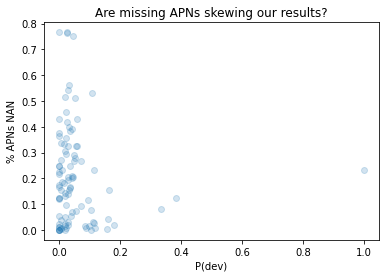

In [54]:
x = results_df["P(dev) for inventory"]
y = [utils.fraction_apns_nan(p) for c, p in cities_with_permits.items()]
plt.scatter(x, y, alpha=.2)
plt.xlabel("P(dev)")
plt.ylabel("% APNs NAN")
plt.title("Are missing APNs skewing our results?")

In [55]:
%%time
with HiddenPrints():
    results_geo_df = pd.DataFrame([get_results_for_city(city, match_by='geo') for city in cities])

CPU times: user 1min 16s, sys: 2.79 s, total: 1min 19s
Wall time: 1min 20s


In [56]:
results_geo_df.round(3)

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
0,Berkeley,0.348,1.255,0.041,0.018,0.013,0.015,3 / 167,3 / 237,6 / 404
1,Albany,0.634,NaN,0.000,0.000,0.000,0.000,0 / 33,0 / 8,0 / 41
2,Alameda,0.535,NaN,0.000,0.143,0.273,0.222,1 / 7,3 / 11,4 / 18
3,Livermore,0.577,1.238,0.245,0.051,0.175,0.114,5 / 99,18 / 103,23 / 202
4,Fremont,0.876,0.438,0.112,0.050,0.095,0.056,7 / 141,2 / 21,9 / 162
...,...,...,...,...,...,...,...,...,...,...
93,Monte Sereno,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6
94,Healdsburg,0.511,0.279,0.028,0.042,0.056,0.050,1 / 24,2 / 36,3 / 60
95,Fairfield,0.320,0.300,0.001,0.000,0.039,0.035,0 / 9,3 / 77,3 / 86
96,Sonoma,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23


In [57]:
%%time
with HiddenPrints():
    results_both_df = pd.DataFrame([get_results_for_city(city, match_by='both') for city in cities])

CPU times: user 1min 30s, sys: 3.79 s, total: 1min 33s
Wall time: 1min 37s


In [58]:
results_both_df.round(3)

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
0,Berkeley,0.348,1.255,0.041,0.018,0.025,0.022,3 / 167,6 / 237,9 / 404
1,Albany,0.634,NaN,0.000,0.000,0.000,0.000,0 / 33,0 / 8,0 / 41
2,Alameda,0.535,NaN,0.000,0.143,0.273,0.222,1 / 7,3 / 11,4 / 18
3,Livermore,0.577,1.238,0.245,0.091,0.233,0.163,9 / 99,24 / 103,33 / 202
4,Fremont,0.876,0.438,0.112,0.050,0.095,0.056,7 / 141,2 / 21,9 / 162
...,...,...,...,...,...,...,...,...,...,...
93,Monte Sereno,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6
94,Healdsburg,0.511,0.279,0.028,0.083,0.083,0.083,2 / 24,3 / 36,5 / 60
95,Fairfield,0.320,0.300,0.001,0.000,0.039,0.035,0 / 9,3 / 77,3 / 86
96,Sonoma,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23


### Histograms of QOIs

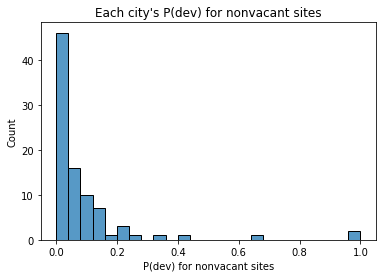

In [59]:
sea_plot = sea.histplot(results_both_df['P(dev) for nonvacant sites']).set_title("Each city's P(dev) for nonvacant sites")
sea_plot.get_figure().savefig('./figures/Pdev_nonvacant.png')

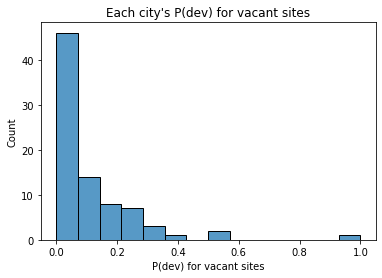

In [60]:
sea_plot = sea.histplot(results_both_df['P(dev) for vacant sites']).set_title("Each city's P(dev) for vacant sites")
sea_plot.get_figure().savefig('./figures/Pdev_vacant.png')

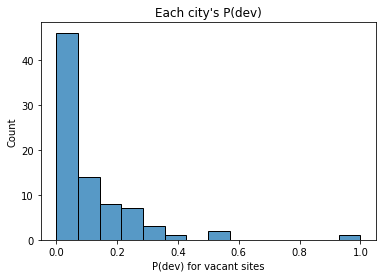

In [61]:
sea_plot = sea.histplot(results_both_df['P(dev) for vacant sites']).set_title("Each city's P(dev)")
sea_plot.get_figure().savefig('./figures/Pdev.png')

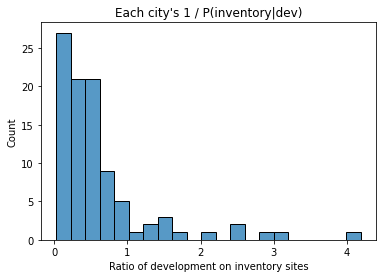

In [62]:
sea_plot = sea.histplot(results_both_df['Ratio of development on inventory sites']).set_title("Each city's 1 / P(inventory|dev)")
sea_plot.get_figure().savefig('./figures/ratio_of_dev.png')

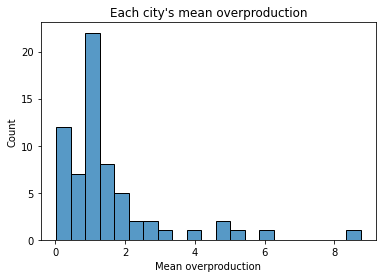

In [63]:
sea_plot = sea.histplot(results_both_df['Mean overproduction']).set_title("Each city's mean overproduction")
sea_plot.get_figure().savefig('./figures/mean_overproduction.png')

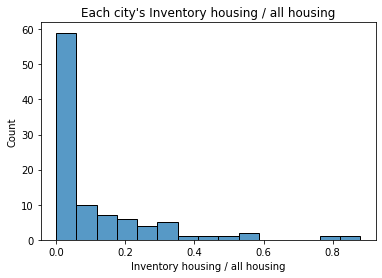

In [64]:
sea_plot = sea.histplot(results_both_df['Inventory housing / all housing']).set_title("Each city's Inventory housing / all housing")
sea_plot.get_figure().savefig('./figures/inventory_housing_over_all_housing.png')


### Did RHNA success in last cycle actually have anything to do with how good the site inventory was?

In [65]:
rhna_success = results_both_df['Ratio of development on inventory sites']
p_dev = results_both_df['P(dev) for inventory']

is_null = np.isnan(rhna_success) | np.isnan(p_dev)
stats.pearsonr(rhna_success[~is_null], p_dev[~is_null])

(0.2855681343940921, 0.004797670413478885)

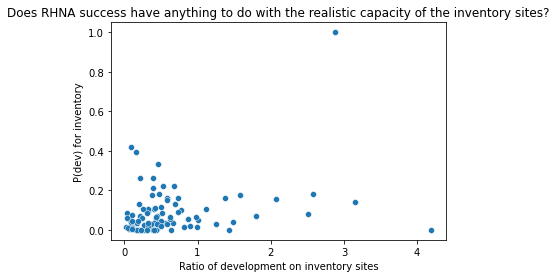

In [66]:
sea_plot = sea.scatterplot(x=rhna_success[~is_null], y=p_dev[~is_null])
sea_plot.set_title("Does RHNA success have anything to do with the realistic capacity of the inventory sites?")
sea_plot.get_figure().savefig('./figures/did_realistic_capacity_calcs_matter.png')

### Table of top 10 cities by P(dev) & bottom 10

#### Worst

In [67]:
results_both_df.sort_values(by='P(dev) for inventory').head(10)

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
1,Albany,0.633907,NaN,0.0,0.0,0.0,0.0,0 / 33,0 / 8,0 / 41
93,Monte Sereno,1.424242,NaN,0.0,0.0,NaN,0.0,0 / 6,0 / 0,0 / 6
88,Suisun City,0.221392,NaN,0.0,0.0,0.0,0.0,0 / 5,0 / 31,0 / 36
86,Rohnert Park,4.184211,NaN,0.0,0.0,0.0,0.0,0 / 34,0 / 1,0 / 35
80,Saratoga,0.307407,NaN,0.0,0.0,NaN,0.0,0 / 14,0 / 0,0 / 14
29,Hercules,0.271691,NaN,0.0,NaN,0.0,0.0,0 / 0,0 / 14,0 / 14
72,Los Gatos,0.167296,NaN,0.0,0.0,0.0,0.0,0 / 33,0 / 3,0 / 36
66,East Palo Alto,0.315542,NaN,0.0,0.0,0.0,0.0,0 / 31,0 / 8,0 / 39
20,Antioch,0.394536,NaN,0.0,0.0,0.0,0.0,0 / 6,0 / 3,0 / 9
39,Tiburon,0.428571,NaN,0.0,0.0,0.0,0.0,0 / 3,0 / 2,0 / 5


#### Best

In [68]:
results_both_df.sort_values(by='P(dev) for inventory', ascending=False).head(10)

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
58,Colma,2.884615,2.538462,0.880000,1.000000,NaN,1.000000,1 / 1,0 / 0,1 / 1
89,Cotati,0.094170,NaN,0.488095,0.654545,0.000000,0.418605,36 / 55,0 / 31,36 / 86
97,Windsor,0.161681,NaN,0.025000,0.425532,0.000000,0.392157,20 / 47,0 / 4,20 / 51
49,San Bruno,0.463822,0.426667,0.128000,0.333333,NaN,0.333333,2 / 6,0 / 0,2 / 6
90,Dixon,0.210740,0.118490,0.110577,0.125000,0.363636,0.263158,1 / 8,4 / 11,5 / 19
73,Milpitas,0.388778,0.468769,0.529185,0.274390,0.000000,0.263158,45 / 164,0 / 7,45 / 171
2,Alameda,0.534967,NaN,0.000000,0.142857,0.272727,0.222222,1 / 7,3 / 11,4 / 18
10,Pleasanton,0.677842,0.928975,0.330193,0.179487,0.275862,0.220588,7 / 39,8 / 29,15 / 68
57,San Mateo,0.398504,1.359946,0.442080,0.046875,0.566667,0.212766,3 / 64,17 / 30,20 / 94
71,San Jose,0.476356,1.097829,0.296018,0.213740,0.116505,0.180301,84 / 393,24 / 206,108 / 599


In [69]:
combined_df = results_df.merge(
    results_geo_df,
    on='City',
    suffixes=[' (by APN)', ' (by geomatching)']
)

In [70]:
combined_df.round(3)

,City,Ratio of development on inventory sites (by APN),Mean overproduction (by APN),Inventory housing / all housing (by APN),P(dev) for nonvacant sites (by APN),P(dev) for vacant sites (by APN),P(dev) for inventory (by APN),# nonvacant matches (by APN),# vacant matches (by APN),# matches (by APN),Ratio of development on inventory sites (by geomatching),Mean overproduction (by geomatching),Inventory housing / all housing (by geomatching),P(dev) for nonvacant sites (by geomatching),P(dev) for vacant sites (by geomatching),P(dev) for inventory (by geomatching),# nonvacant matches (by geomatching),# vacant matches (by geomatching),# matches (by geomatching)
0,Berkeley,0.348,1.255,0.041,0.012,0.025,0.020,2 / 167,6 / 237,8 / 404,0.348,1.255,0.041,0.018,0.013,0.015,3 / 167,3 / 237,6 / 404
1,Albany,0.634,NaN,0.000,0.000,0.000,0.000,0 / 33,0 / 8,0 / 41,0.634,NaN,0.000,0.000,0.000,0.000,0 / 33,0 / 8,0 / 41
2,Alameda,0.535,NaN,0.000,0.000,0.000,0.000,0 / 7,0 / 11,0 / 18,0.535,NaN,0.000,0.143,0.273,0.222,1 / 7,3 / 11,4 / 18
3,Livermore,0.577,1.238,0.245,0.071,0.165,0.119,7 / 99,17 / 103,24 / 202,0.577,1.238,0.245,0.051,0.175,0.114,5 / 99,18 / 103,23 / 202
4,Fremont,0.876,0.438,0.112,0.028,0.048,0.031,4 / 141,1 / 21,5 / 162,0.876,0.438,0.112,0.050,0.095,0.056,7 / 141,2 / 21,9 / 162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Monte Sereno,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6,1.424,NaN,0.000,0.000,NaN,0.000,0 / 6,0 / 0,0 / 6
94,Healdsburg,0.511,0.279,0.028,0.083,0.083,0.083,2 / 24,3 / 36,5 / 60,0.511,0.279,0.028,0.042,0.056,0.050,1 / 24,2 / 36,3 / 60
95,Fairfield,0.320,0.300,0.001,0.000,0.026,0.023,0 / 9,2 / 77,2 / 86,0.320,0.300,0.001,0.000,0.039,0.035,0 / 9,3 / 77,3 / 86
96,Sonoma,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23,0.182,0.103,0.029,0.000,0.200,0.043,0 / 18,1 / 5,1 / 23


In [71]:
results_df.to_csv('results/apn_matching_results.csv')
results_geo_df.to_csv('results/geo_matching_results.csv')
combined_df.to_csv('results/combined_df.csv')
results_both_df.to_csv('results/apn_or_geo_matching_results.csv')

Let's look into some cities where the APN results and Geo results are very out of line:

In [72]:
combined_df[
    (combined_df['P(dev) for nonvacant sites (by APN)'] - combined_df['P(dev) for nonvacant sites (by geomatching)']).abs() > 0.3
]

,City,Ratio of development on inventory sites (by APN),Mean overproduction (by APN),Inventory housing / all housing (by APN),P(dev) for nonvacant sites (by APN),P(dev) for vacant sites (by APN),P(dev) for inventory (by APN),# nonvacant matches (by APN),# vacant matches (by APN),# matches (by APN),Ratio of development on inventory sites (by geomatching),Mean overproduction (by geomatching),Inventory housing / all housing (by geomatching),P(dev) for nonvacant sites (by geomatching),P(dev) for vacant sites (by geomatching),P(dev) for inventory (by geomatching),# nonvacant matches (by geomatching),# vacant matches (by geomatching),# matches (by geomatching)
49,San Bruno,0.463822,0.426667,0.128000,0.333333,NaN,0.333333,2 / 6,0 / 0,2 / 6,0.463822,0.426667,0.128000,0.000000,NaN,0.000000,0 / 6,0 / 0,0 / 6
58,Colma,2.884615,2.538462,0.880000,1.000000,NaN,1.000000,1 / 1,0 / 0,1 / 1,2.884615,2.538462,0.880000,0.000000,NaN,0.000000,0 / 1,0 / 0,0 / 1
64,Portola Valley,0.585185,1.375000,0.139241,0.000000,0.105263,0.102564,0 / 2,8 / 76,8 / 78,0.585185,1.375000,0.139241,1.000000,0.118421,0.141026,2 / 2,9 / 76,11 / 78
97,Windsor,0.161681,NaN,0.025000,0.106383,0.000000,0.098039,5 / 47,0 / 4,5 / 51,0.161681,NaN,0.025000,0.425532,0.000000,0.392157,20 / 47,0 / 4,20 / 51


In [75]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:
    print(column, (combined_df[column + ' (by geomatching)'] >= combined_df[column + ' (by APN)']).mean())

P(dev) for nonvacant sites 0.7959183673469388
P(dev) for vacant sites 0.7244897959183674
P(dev) for inventory 0.8163265306122449


In [76]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:
    print(column, (combined_df[column + ' (by geomatching)'] == combined_df[column + ' (by APN)']).mean())

P(dev) for nonvacant sites 0.3979591836734694
P(dev) for vacant sites 0.37755102040816324
P(dev) for inventory 0.35714285714285715


# "Ground truth" data

In [77]:
def get_ground_truth_results_for_city(city: str) -> pd.DataFrame:
    if city == 'San Jose':
        permits = san_jose_permits.load_all_permits()
    elif city == 'San Francisco':
        permits = san_francisco_permits.load_all_permits()
    elif city == 'Los Altos':
        permits = los_altos_permits.load_all_permits()
    else:
        raise ValueError(f"Ground truth data not available for {city}")
        
    permits = utils.load_all_new_building_permits(city)
    sites = utils.load_site_inventory(city)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': utils.calculate_pdev_for_nonvacant_sites(sites, permits),
        'P(dev) for vacant sites': utils.calculate_pdev_for_vacant_sites(sites, permits),
        'P(dev) for inventory': utils.calculate_pdev_for_inventory(sites, permits),
    }

In [78]:
permits = pd.read_csv("./data/raw_data/sf_permits.csv")
print(permits.columns)
date_cols = [c for c in permits.columns if 'Date' in c]
permits[date_cols] = permits[date_cols].apply(pd.to_datetime)

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (22,31,34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit',
       'Unit Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit', 'Estimated Cost',
       'Revised Cost', 'Existing Use', 'Existing Units', 'Proposed Use',
       'Proposed Units', 'Plansets', 'TIDF Compliance',
       'Existing Construction Type', 'Existing Construction Type Description',
       'Proposed Construction Type', 'Proposed Construction Type Description',
       'Site Permit', 'Supervisor District',
       'Neighborhoods - Analysis Boundaries', 'Zipcode', 'Record ID'],
      dtype='object')


In [79]:
print(permits.columns)

Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit',
       'Unit Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit', 'Estimated Cost',
       'Revised Cost', 'Existing Use', 'Existing Units', 'Proposed Use',
       'Proposed Units', 'Plansets', 'TIDF Compliance',
       'Existing Construction Type', 'Existing Construction Type Description',
       'Proposed Construction Type', 'Proposed Construction Type Description',
       'Site Permit', 'Supervisor District',
       'Neighborhoods - Analysis Boundaries', 'Zipcode', 'Record ID'],
      dtype='object')


In [80]:
%%time
ground_truth_cities = ['Los Altos', 'San Francisco', 'San Jose']
ground_truth_results_df = pd.DataFrame([get_ground_truth_results_for_city(city) for city in ground_truth_cities])

Dropping constant columns: ['num_am', 'rhnacyc', 'infcapcty', 'num_m', 'jurisdict', 'county', 'num_l', 'rhnayrs', 'num_vl', 'allowlow']
DF shape (57, 29)
Total units permitted: 532.0
Total realistic capacity in inventory: 257.5
Units permitted on inventory sites: 34.0
Total units permitted: 532.0


<timed exec>:2: DtypeWarning: Columns (18,22,32,35) have mixed types.Specify dtype option on import or set low_memory=False.
/Users/sidharthkapur/personal-workspace/housing-elements/housing_elements/san_francisco_permits.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rhna_permits.sort_values(by="Permit Type", axis=0, inplace=True)


Dropping constant columns: ['currunits', 'num_am', 'rhnacyc', 'num_m', 'jurisdict', 'county', 'num_l', 'rhnayrs', 'num_vl', 'allowlow']
DF shape (6158, 29)
Total units permitted: 26071
Total realistic capacity in inventory: 47209
Units permitted on inventory sites: 5079
Total units permitted: 26071
Dropping constant columns: ['currunits', 'num_am', 'rhnacyc', 'num_m', 'jurisdict', 'county', 'num_l', 'rhnayrs', 'num_vl', 'allowlow']
DF shape (599, 29)
Total units permitted: 16928.0
Total realistic capacity in inventory: 35536.43
Units permitted on inventory sites: 5011.0
Total units permitted: 16928.0
CPU times: user 51.6 s, sys: 2.6 s, total: 54.2 s
Wall time: 1min 22s


In [81]:
ground_truth_results_df

,City,Ratio of development on inventory sites,Mean overproduction,Inventory housing / all housing,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory
0,Los Altos,2.066019,0.944444,0.063910,"(3, 34, 0.08823529411764706)","(6, 23, 0.2608695652173913)","(9, 57, 0.15789473684210525)"
1,San Francisco,0.552246,4.676239,0.194814,"(95, 3915, 0.024265644955300127)","(50, 1339, 0.037341299477221805)","(145, 5254, 0.027598020555767034)"
2,San Jose,0.476356,1.097829,0.296018,"(53, 393, 0.13486005089058525)","(14, 206, 0.06796116504854369)","(67, 599, 0.11185308848080133)"
